In [1]:
import torch
from fastai.vision.all import *

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

/home/ippen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available on this system.


In [2]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

(88, 35)


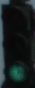

In [3]:
project_path = '/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl/'
city = 'Frankfurt'
image_path = project_path + city + '/images'

files = get_image_files(image_path)
img = PILImage.create(files[15])
print(img.shape)
img.to_thumb(128)

In [4]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(30, 70)     19
(32, 78)     19
(31, 74)     18
(30, 72)     17
(31, 76)     16
             ..
(40, 91)      1
(48, 128)     1
(51, 137)     1
(60, 112)     1
(45, 107)     1
Length: 905, dtype: int64

In [5]:
# Check Maximal Image Size
max_size = 0
for i in range(len(files)):
    img = PILImage.create(files[i])
    if max_size < img.shape[0]:
        max_size = img.shape[0]
    if max_size < img.shape[1]:
        max_size = img.shape[1]
print(max_size)

200


In [6]:
def get_label_func(file_name, labels_file):
    # Load the JSON file with class labels
    with open(labels_file, "r") as f:
        labels_data = json.load(f)

    # Extract the class label based on the file name
    tl = labels_data[file_name]
    return tl["state"] + tl["pictogram"]

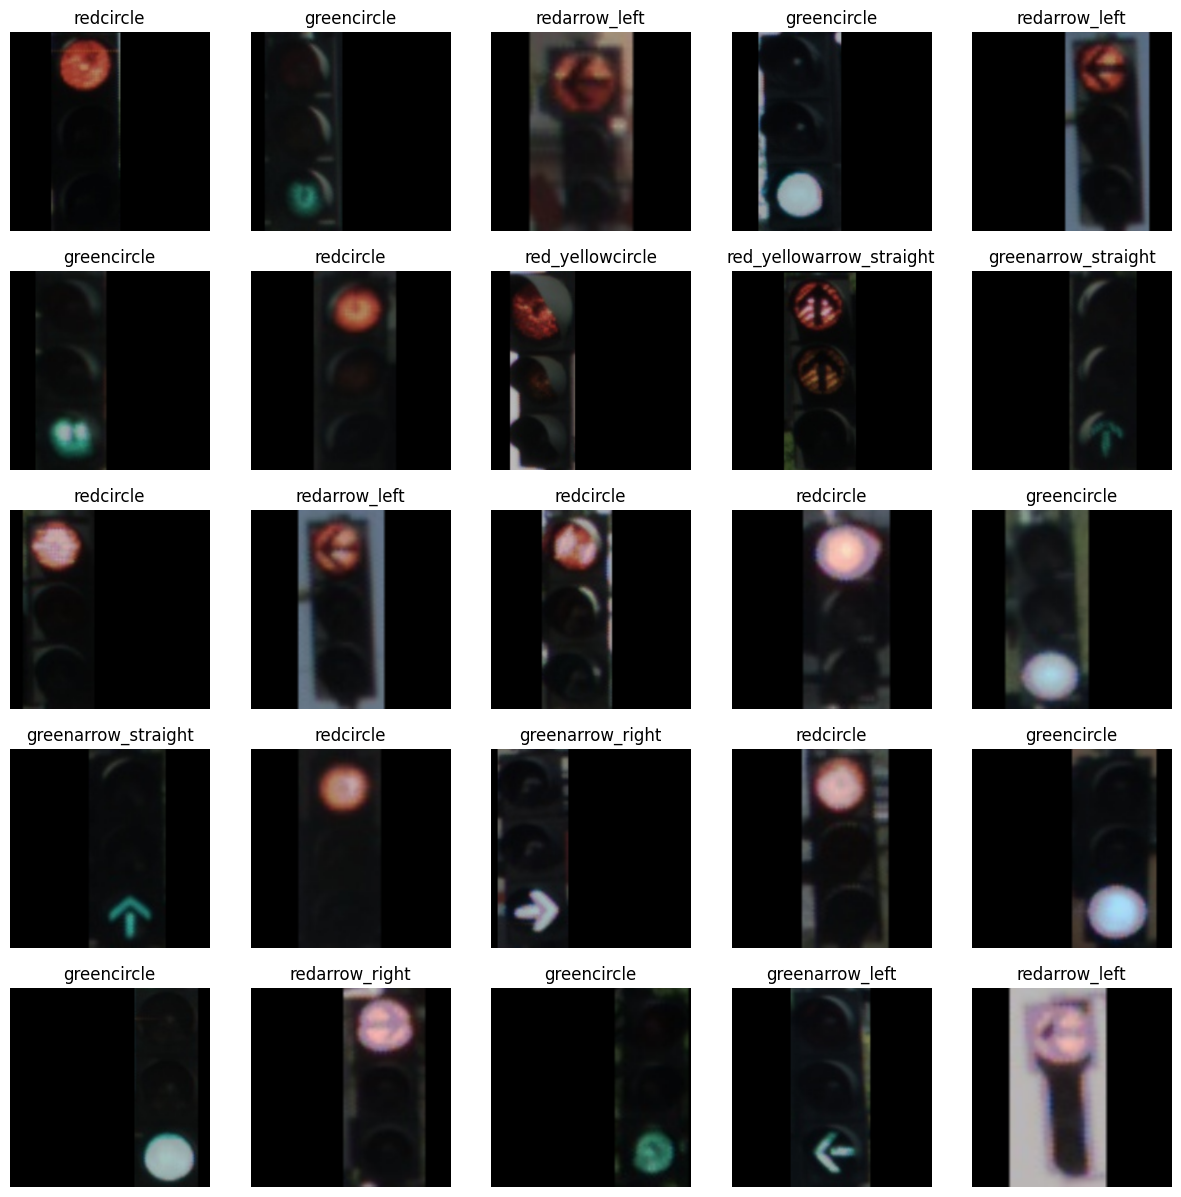

In [9]:
dls = ImageDataLoaders.from_name_func(image_path, get_image_files(project_path + city), valid_pct=0.2, seed=42,
    item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
    batch_tfms=None,
    label_func=lambda file_name: get_label_func(file_name, project_path + city + '/labels.json'))

dls.show_batch(max_n=25)

In [8]:
# Check all cities
def examine_dataset(cities):
    max_length = len(max(cities, key=len))
    max_size = 5
    first_line = True
    for city in cities:
        missing_class_str = city + " "*(max_length - len(city)) + " | "
        
        labels_file = project_path + city + '/labels.json'
        dls = ImageDataLoaders.from_name_func(image_path, get_image_files(project_path + city), valid_pct=0.2, seed=42,
            item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
            batch_tfms=None,
            label_func=lambda file_name: get_label_func(file_name, labels_file))
        
        header_str = "City" + " "*(max_length - len("City")) + " | "
        for state in ["red", "red_yellow", "yellow", "green", "off"]:
            for pictogram in ["circle", "arrow_left", "arrow_straight", "arrow_right"]:    
                class_label = state + pictogram
                if first_line:
                    header_str += class_label + " "*max_size + " | " 
                # Count the occurrences of the class label in the training set
                num_train_items = sum(1 for item in dls.train.items if get_label_func(item.name, labels_file) == class_label)
                # Count the occurrences of the class label in the validation set
                num_valid_items = sum(1 for item in dls.valid.items if get_label_func(item.name, labels_file) == class_label)
                
                if num_train_items + num_valid_items > 0:
                    missing_class_str += class_label + " "*(max(0, max_size-len(str(num_train_items + num_valid_items)))) + str(num_train_items + num_valid_items) + " | "
                else:
                    missing_class_str += " "*(len(class_label)+ max_size) + " | "
        num_images = len(dls.train.items) + len(dls.valid.items)
        missing_class_str += str(num_images) + " "*(max(0, max_size-len(str(num_images)))) + " |"
        if first_line:
            header_str += "Total" + " "*(max_size - len("Total")) + " | "
            print(header_str)
            first_line = False
        print(missing_class_str)

examine_dataset(cities = ['Berlin', 'Bochum', 'Bremen', 'Dortmund', 'Duesseldorf', 'Essen', 'Frankfurt', "Fulda", "Hannover", "Kassel", "Koeln"])


City        | redcircle      | redarrow_left      | redarrow_straight      | redarrow_right      | red_yellowcircle      | red_yellowarrow_left      | red_yellowarrow_straight      | red_yellowarrow_right      | yellowcircle      | yellowarrow_left      | yellowarrow_straight      | yellowarrow_right      | greencircle      | greenarrow_left      | greenarrow_straight      | greenarrow_right      | offcircle      | offarrow_left      | offarrow_straight      | offarrow_right      | Total | 
Berlin      | redcircle  384 | redarrow_left   48 | redarrow_straight    7 | redarrow_right   27 | red_yellowcircle   54 | red_yellowarrow_left    1 |                               |                            | yellowcircle   46 | yellowarrow_left    2 |                           | yellowarrow_right    2 | greencircle  784 | greenarrow_left   45 | greenarrow_straight    7 | greenarrow_right    5 | offcircle  125 |                    |                        |                     | 1537  |
Bochum   

### Train and Validation Split
- Train: Berlin, Bochum, Bremen, Duesseldorf, Essen, Fulda, Hannover, Kassel, Koeln
- Validation: Frankfurt Dortmund